In [3]:
import numpy as np
import utils.prepare as prepare
import utils.models as models
import utils.LDA as LDA
import utils.fast_test as fast_test
import matplotlib.pyplot as plt
from skimage.io import imread
import utils.plot as plot
import heapq
import glob

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU,Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import *
tf.compat.v1.enable_eager_execution()

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import keras

In [4]:
print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.1.0-dev20191014
TensorFlow Probability version: 0.8.0


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # GPU memory
session = tf.compat.v1.Session(config=config)

In [6]:
def load_data(txtfolder_name,imagefloder_name,image_x,image_y):
    all_count = 1
    all_label = np.zeros(1,dtype=np.int)
    image_data = np.zeros([1,30,30,3],dtype=np.uint8)
    read_files = glob.glob(str('./')+txtfolder_name+str('/*.txt'))
    for name in read_files:
        name = name.split("/")[2]
        name = name.split(".")[0]
        path_txt = str('./')+txtfolder_name+str('/')+name+str('.txt')
        path_image = str('./')+ imagefloder_name+str('/')+name+str('.jpg')
        new_image_data,label = generate_signal_imagedata(path_txt,path_image,image_x,image_y)
        all_label = np.hstack((all_label,label))
        image_data = np.vstack((image_data,new_image_data))
        print("Image {0} is finish ".format(all_count))
        all_count = all_count+1
    final_data = image_data[1:,:,:,:]
    final_label = all_label[1:]
    return final_data,final_label

def generate_signal_imagedata(path_txt,path_image,image_x,image_y):
    txt_file = open(path_txt)
    text = txt_file.readlines()[2:]
    count_points = len(text)
    
    crop_length = 30
    crop_width = 30
    all_image = np.zeros([count_points,crop_length,crop_width,3],dtype=np.uint8)
    label = np.zeros(count_points,dtype=np.int)
    crop_x = int(crop_length/2)
    crop_y = int(crop_width/2)
    image = imread(path_image)
    for i in range(count_points):
        text_piece = text[i]
        text_element = text_piece.split(',')
        l_x = int(float(text_element[0]))
        l_y = int(float(text_element[1]))
        label[i] = int(text_element[2])
        if(l_x-crop_x <0):
            l_x = crop_x
        if(l_y-crop_y <0):
            l_y = crop_y
        if(l_x+crop_x >image_y):
            l_x = image_y-15
        if(l_y+crop_y >image_x):
            l_y =image_x-15
        all_image[i,:,:,:] = image[l_y-15:l_y+15,l_x-15:l_x+15]
    txt_file.close()
    return all_image,label


In [7]:
print('Loading coral dataset')
data2012_raw_data,data2012_raw_label = load_data('2012data_label augmentation(m=300)','2012image',1536,2048)
#data2012_area_data,data2012_area_label = load_data('2012area','2012image',1536,2048)


Loading coral dataset
Image 1 is finish 
Image 2 is finish 
Image 3 is finish 
Image 4 is finish 
Image 5 is finish 
Image 6 is finish 
Image 7 is finish 
Image 8 is finish 
Image 9 is finish 
Image 10 is finish 
Image 11 is finish 
Image 12 is finish 
Image 13 is finish 
Image 14 is finish 
Image 15 is finish 
Image 16 is finish 
Image 17 is finish 
Image 18 is finish 
Image 19 is finish 
Image 20 is finish 
Image 21 is finish 
Image 22 is finish 
Image 23 is finish 
Image 24 is finish 
Image 25 is finish 
Image 26 is finish 
Image 27 is finish 
Image 28 is finish 
Image 29 is finish 
Image 30 is finish 
Image 31 is finish 
Image 32 is finish 
Image 33 is finish 
Image 34 is finish 
Image 35 is finish 
Image 36 is finish 
Image 37 is finish 
Image 38 is finish 
Image 39 is finish 
Image 40 is finish 
Image 41 is finish 
Image 42 is finish 
Image 43 is finish 
Image 44 is finish 
Image 45 is finish 
Image 46 is finish 
Image 47 is finish 
Image 48 is finish 
Image 49 is finish 
Image 5

In [8]:
data2012_raw_data.shape
#data2012_area_data.shape
#data2012_all = np.vstack((data2012_raw_data,data2012_area_data))
#data2012_all_label = np.hstack((data2012_raw_label,data2012_area_label))

(66000, 30, 30, 3)

In [9]:
data2012_all_label.shape

NameError: name 'data2012_all_label' is not defined

In [ ]:
all_patch_image = prepare.image2patch("2012image",30,[1532,2048])

In [10]:
def data_shuffle(data,label):
    data = data.reshape(-1,2700)
    data, label = shuffle(data, label)
    shuffle_data = data.reshape(-1,30,30,3)
    return shuffle_data,label

In [11]:
shuffle_data,shuffle_label = data_shuffle(data2012_raw_data,data2012_raw_label)
shuffle_data.shape

(66000, 30, 30, 3)

In [12]:
X_train = shuffle_data[0:12000]
X_test = shuffle_data[12000:13200]
y_train = shuffle_label[0:12000]
y_test = shuffle_label[12000:13200]

In [13]:
n_class = 6
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
n_train = X_train.shape[0]
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

X_train.shape = (12000, 30, 30, 3)
y_train.shape = (12000, 6)
X_test.shape = (1200, 30, 30, 3)
y_test.shape = (1200, 6)


array([[[0.47058824, 0.28235295, 0.27450982],
        [0.44313726, 0.27058825, 0.26666668],
        [0.41568628, 0.25882354, 0.25882354],
        ...,
        [0.5647059 , 0.3647059 , 0.38431373],
        [0.5294118 , 0.32941177, 0.31764707],
        [0.49803922, 0.30588236, 0.2901961 ]],

       [[0.47058824, 0.29803923, 0.28627452],
        [0.44705883, 0.2901961 , 0.28235295],
        [0.42745098, 0.2784314 , 0.26666668],
        ...,
        [0.46666667, 0.2509804 , 0.27058825],
        [0.44705883, 0.25490198, 0.23529412],
        [0.43529412, 0.2509804 , 0.22745098]],

       [[0.4745098 , 0.3254902 , 0.2901961 ],
        [0.4509804 , 0.32156864, 0.28627452],
        [0.42745098, 0.3137255 , 0.28235295],
        ...,
        [0.41568628, 0.2       , 0.21176471],
        [0.40392157, 0.21960784, 0.19607843],
        [0.41568628, 0.23137255, 0.2       ]],

       ...,

       [[0.38431373, 0.25882354, 0.2627451 ],
        [0.4117647 , 0.25882354, 0.27058825],
        [0.41960785, 0

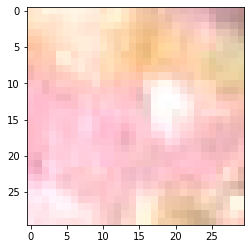

In [14]:
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[25, :, :, :])
X_train[0, :, :, :]

In [15]:
batch_size = 128
n_epochs = 100
lr = 1e-3
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same",
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(32, kernel_size=(3, 3),
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    conv_3 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same",
                                  kernel_divergence_fn=None)
    conv_3 = add_kl_weight(conv_3, train_size)
    x = conv_3(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_4 = Convolution2DFlipout(64, kernel_size=(3, 3),
                                  kernel_divergence_fn=None)
    conv_4 = add_kl_weight(conv_4, train_size)
    x = conv_4(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    conv_5 = Convolution2DFlipout(128, kernel_size=(3, 3), padding="same",
                                  kernel_divergence_fn=None)
    conv_5 = add_kl_weight(conv_5, train_size)
    x = conv_5(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_6 = Convolution2DFlipout(128, kernel_size=(3, 3),
                                  kernel_divergence_fn=None)
    conv_6 = add_kl_weight(conv_6, train_size)
    x = conv_6(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    x = Dropout(0.25)(x)
    dense_2 = DenseFlipout(6, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], 50000)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=tf.keras.optimizers.Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 30, 30, 32)        1761      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 32)        18465     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
______________________________________________________

In [ ]:
#bcnn_model.load_weights("model_coral.h5")

In [ ]:
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, 
                      verbose=1, validation_split=0.1)

In [ ]:
bcnn_model.save_weights('./model_weights/bcnn_12000.h5')

In [ ]:
bcnn_model.load_weights('./model_weights/bcnn_6000.h5')

In [ ]:
names = []
qmeans = []
qstds = []
pmeans = []
pstds = []
for i, layer in enumerate(bcnn_model.layers):
    try:
      q = layer.kernel_posterior
      p = layer.kernel_prior
    except AttributeError:
      continue
    names.append("Layer {}".format(i))
    qmeans.append(q.mean())
    qstds.append(q.stddev())
    pmeans.append(p.mean())
    pstds.append(p.stddev())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,axs = plt.subplots(1,2,figsize=(10, 5))
for n, qm in zip(names, qmeans):
    qm = np.array(qm)
    sns.distplot(qm.flatten(), ax = axs[0],label=n)
#fig.suptitle('This is a somewhat long figure title', fontsize=16)
axs[0].legend()
axs[0].set_title('weight means in each layer')

for n, qs in zip(names, qstds):
    qs = np.array(qs)
    sns.distplot(qs.flatten(), ax = axs[1],label=n)
axs[1].legend()
axs[1].set_title('weight stddevs in each layer')  

In [ ]:
def percent_coral(testimage):
    count = 0 
    #blue = np.array([0,0,255], dtype=np.uint8)
    test = np.uint8(testimage)
    f = np.where(test[:,:,2]==255)
    count = len(f[0])
    all_pixel = test.shape[0]*test.shape[1]
    coral_percent = (count/all_pixel)*100 
    coral_percent = round(coral_percent,2)
    return coral_percent


def fun(x,y):
    f = test_image[x:x+30,y:y+30]
    f = f.reshape(2700)
    return f

In [ ]:
name = '201208172_T-12-58-58_Dive_01_041'
path_image = './2012image/'+str(name)+'.jpg'
file_image ='2012image'
name_image = str(name)
stride = 6
test_image = imread(path_image)

In [ ]:
check_palindrome = np.frompyfunc(fun, 2, 1)
x = np.arange(0,test_image.shape[0] - 30+1, stride)
y = np.arange(0,test_image.shape[1] - 30+1, stride)
X,Y = np.meshgrid(x, y)
#%%
zs = check_palindrome(np.ravel(X.T), np.ravel(Y.T))
fs = np.concatenate(zs,axis=0).astype(np.uint8)
image_all_patches = fs.reshape(len(x)*len(y),30,30,3)/255

In [ ]:
n_mc_run = 2
y_pred_logits_list = [bcnn_model.predict(image_all_patches,verbose=1) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)

In [ ]:
#y_pred_prob_all.shape
y_mean_pred = np.mean(y_pred_prob_all,axis=-1)

In [ ]:
y_mean_pred.shape

In [ ]:
def heatmap2d(arr: np.ndarray,savenum):
    plt.imshow(arr, cmap="YlGnBu")#,vmin=0, vmax=0.1)
    plt.colorbar()


    #plt.savefig("output_"+str(savenum)+".pdf")
    plt.show()
    
 
def array2heatmap(array,x,y,stride,savenum):
    y_pred = array[:,0]
    y_pred = y_pred.reshape(x,y)
    array_y_pred = y_pred.repeat(stride,axis = 0).repeat(stride, axis = 1)
    heatmap2d(array_y_pred,savenum)
    plt.close()

In [ ]:
array2heatmap(y_mean_pred,252,337,6,'12000')

In [ ]:
def heatmap2d(arr: np.ndarray,savenum):
    plt.imshow(arr, cmap="YlGnBu")#,vmin=0, vmax=0.1)
    plt.colorbar()


    #plt.savefig("output_"+str(savenum)+".pdf")
    plt.show()
    
 
def array2heatmap(array,x,y,stride,savenum):
    y_pred = array[:,0]
    y_pred = y_pred.reshape(x,y)
    array_y_pred = y_pred.repeat(stride,axis = 0).repeat(stride, axis = 1)
    heatmap2d(array_y_pred,savenum)
    plt.close()
    

In [ ]:
n_mc_run = 1
med_prob_thres = 0.2

y_pred_logits_list = [bcnn_model.predict(X_test,verbose=1) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)

In [ ]:
y_pre_train = np.argmax(y_pred_prob_all[:,:,0],axis=-1)
g = np.where(y_pre_train==np.argmax(y_test,axis=-1))
len(g[0])

In [ ]:
np.save("all_patches_result.npy",y_pred_prob_all)

In [ ]:
y_pred = [[int(np.median(y) >= 0.2) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

In [ ]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=4, figsize=(10, 15)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

In [ ]:
true_coral_test = np.where(np.argmax(y_test,axis=-1)==0)[0]
pre_prob = np.zeros(len(true_coral_test))
for i, index in enumerate(true_coral_test):
    pre_prob[i] = (np.sum(y_pred_prob_all[index][0]))/500

index_coral = np.argsort(pre_prob)[::-1]

In [ ]:
prob_large = pre_prob[pre_prob>0.5]
index_large = np.argsort(prob_large)[::-1]
index_show = np.int16(np.where(pre_prob==prob_large[index_large[0]]))[0][0]

In [ ]:
idx = true_coral_test[index_show]
plt.imshow(X_test[idx, :, :, :])
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

#if any(y_pred[idx]):
print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))